# Policy gradient (REINFORCE)
Refer to the lecture note `9PolGrad.pdf`

## To run jupyter without remote redering (e.g. on a local machine), execute jupyter by:
`jupyter notebook --ip=YOUR_IP --notebook-dir YOUR_WORKING_DIR`

## To run jupyter with remote redering (e.g. on a remote machine), execute jupyter by:
`xvfb-run -s "-screen 0 600x400x24" jupyter notebook --ip=YOUR_IP --notebook-dir YOUR_WORKING_DIR`

## Important argument
`do_render`: set ```True``` to render (visualize) the environment on the notebook for each step

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

import gym
import numpy as np

In [2]:
%matplotlib inline
from IPython import display
import matplotlib.pyplot as plt

In [3]:
tf.keras.backend.set_floatx('float64')

gamma = 0.99
lr = 0.01
do_render = False
print_freq = 100
max_episodes=1000

optimizer = Adam(lr)

In [4]:
def show_state(env, info=""):
    plt.figure(3)
    plt.clf()
    plt.imshow(env.render(mode='rgb_array'))
    plt.title(info)
    plt.axis('off')

    display.clear_output(wait=True)
    display.display(plt.gcf())

In [5]:
# state -> action들의 확률값
class PolicyNetworks(tf.keras.Model):
    def __init__(self, state_dim, action_dim):
        super(PolicyNetworks, self).__init__()
        self.state_dim = state_dim
        self.action_dim = action_dim

        self.net = self.create_model()

    def create_model(self):
        model = tf.keras.Sequential([
            # 여러개의 dense layers
            Input((self.state_dim,)), # 4
            Dense(8, activation='relu'),
            Dense(self.action_dim, activation='softmax') # 2
        ])
        return model
    
    def call(self, x):
        return self.net(x)
    
    # 매 스텝마다 행동 추정
    # policy gradient는 확률론적 정책을 학습!
    # eps없이 행동들의 확률을 직접 학습
    # DQN: epsilon greedy
    # PG: stochastic policy (확률론적 정책) state에 따라서 각각 action의 확률을 정할 수 있음
    # PG의 단점 : random성이 높다. variance가 높다. (on policy)
    def get_action(self, state):
        # state.shape(4) = [0.0, 0.2, -0.1, 0.3]
        state = state[np.newaxis, ...] # (dim, dim, ...) -> (1, dim, dim, ...)
        
        # state.shape(1, 4) = [[0.0, 0.2, -0.1, 0.3]]
        # PG : 확률분포로 정의 = non-negative, sum=1
        # net의 input (batch_size, dim)
        policy = self.net(state)[0] # 첫번째 row indexing
        # net의 output (batch_size, self.action_dim)
        
        # np.random.choice: 첫번째 인자중에 하나를 p의 확률로 뽑아준다.
        action = np.random.choice(list(range(self.action_dim)), p=policy)
        return action # cartpole : 0, 1

In [6]:
np.random.choice([0,1], p=[0.3,0.7])

1

In [7]:
# T=3
policies = np.array([[0.1, 0.9],
                     [0.2, 0.8],
                     [0.3, 0.7]])
actions = [0, 1, 0]
indiced_actions = tf.constant([[i, a] for i, a in enumerate(actions)])
chosen_prob = tf.gather_nd(policies, indiced_actions)
print("indiced_actions :", indiced_actions)
print("chosen_prob :", chosen_prob)

indiced_actions : tf.Tensor(
[[0 0]
 [1 1]
 [2 0]], shape=(3, 2), dtype=int32)
chosen_prob : tf.Tensor([0.1 0.8 0.3], shape=(3,), dtype=float64)


In [17]:
# 전반적인 학습 관리
class Agent():
    def __init__(self, env):
        self.env = env
        self.state_dim = self.env.observation_space.shape[0]
        self.action_dim = self.env.action_space.n
        self.model = PolicyNetworks(self.state_dim, self.action_dim)

    def discount_rewards(self, rewards):
#         output = [reward*(gamma**index) for index, reward in enumerate(rewards)]
        
        # tf, torch, np
        # ~~_like(x)
        # x의 shape대로 새로운 변수를 만들어줍니다.
        discounted_r = np.zeros_like(rewards)
        for i, r in enumerate(rewards):
            discounted_r[i] = r * tf.math.pow(gamma, i)
        return discounted_r

    def loss_function(self, policies, actions, rewards):
        # policies, actions, rewards : 에피소드 시작부터 끝까지 데이터
        # (episode_length, ) : Eq.8 T
        indiced_actions = tf.constant([[i, a] for i, a in enumerate(actions)]) # 어떤 action 선택했는지
        # agent가 선택했었던 행동의 확률
        chosen_prob = tf.gather_nd(policies, indiced_actions)

        # Eq.8
        # - 이유 : maximum
        loss = -tf.reduce_sum(tf.math.log(chosen_prob)) * tf.reduce_sum(rewards)
        return loss

    def train_step(self, states, actions, rewards):
        with tf.GradientTape() as tape:
            policies = self.model(states)
            loss = self.loss_function(policies, actions, rewards)
        gradients = tape.gradient(loss, self.model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))

    def train(self, max_episodes):
        total_reward = []

        for ep in range(max_episodes): # 게임을 몇 번 하는지
            done, running_reward = False, 0 # 초기화 작업들
            state = self.env.reset()
            # dqn: replay buffer 사용
            # PG: episode마다 (s, a, r)를 갱신 
            #     이전 에피소드에서 경험한 s, a, r은 다날라가고 현재 갖고 있는 s, a, r만남아있음. 예전 episode의 경험은 참고하지 않음
            state_list, action_list, reward_list = [], [], []

            while not done: # 게임 끝날때까지 반복
                action = self.model.get_action(state) # 0, 1
                next_state, reward, done, _ = self.env.step(action)  # Get reward and next state

                state_list.append(state)
                action_list.append(action)
                reward_list.append(reward)

                running_reward += reward
                state = next_state

                if do_render:
#                     self.env.render()  # if you are running on a local machine
                    show_state(self.env, info=f'episode: {ep} | episode reward: {running_reward}')

            # if done, escape from the while loop
            total_reward.append(running_reward)
            
#             discounted_reward_list = tf.cast(reward_list, tf.float64)
            discounted_reward_list = tf.cast(self.discount_rewards(reward_list), tf.float64)
            states_np = np.array(state_list)
            # 학습이 이루어지는 곳
            self.train_step(states_np, action_list, discounted_reward_list)

            if ep % print_freq == 0:
                print(f'episode: {ep:>3} | avg. reward: {np.mean(total_reward[-print_freq:])}')
        return total_reward

In [18]:
env = gym.make('CartPole-v1')
agent = Agent(env)
total_reward = agent.train(max_episodes=max_episodes)

episode:   0 | avg. reward: 8.0
episode: 100 | avg. reward: 11.88
episode: 200 | avg. reward: 12.41
episode: 300 | avg. reward: 11.41
episode: 400 | avg. reward: 12.94
episode: 500 | avg. reward: 14.35
episode: 600 | avg. reward: 15.14
episode: 700 | avg. reward: 17.11
episode: 800 | avg. reward: 21.11
episode: 900 | avg. reward: 16.43


In [8]:
total_reward

[28.0,
 30.0,
 16.0,
 20.0,
 45.0,
 27.0,
 45.0,
 28.0,
 25.0,
 9.0,
 23.0,
 30.0,
 24.0,
 15.0,
 16.0,
 26.0,
 25.0,
 23.0,
 27.0,
 43.0,
 35.0,
 34.0,
 29.0,
 33.0,
 43.0,
 46.0,
 30.0,
 15.0,
 22.0,
 34.0,
 20.0,
 31.0,
 25.0,
 26.0,
 13.0,
 17.0,
 67.0,
 31.0,
 43.0,
 33.0,
 41.0,
 34.0,
 34.0,
 55.0,
 21.0,
 45.0,
 28.0,
 29.0,
 39.0,
 33.0,
 65.0,
 65.0,
 37.0,
 51.0,
 20.0,
 30.0,
 75.0,
 19.0,
 95.0,
 116.0,
 43.0,
 42.0,
 22.0,
 40.0,
 30.0,
 77.0,
 68.0,
 44.0,
 93.0,
 104.0,
 60.0,
 64.0,
 22.0,
 76.0,
 45.0,
 88.0,
 28.0,
 72.0,
 26.0,
 57.0,
 49.0,
 80.0,
 59.0,
 28.0,
 67.0,
 25.0,
 71.0,
 28.0,
 98.0,
 152.0,
 169.0,
 119.0,
 38.0,
 138.0,
 28.0,
 49.0,
 48.0,
 127.0,
 56.0,
 70.0,
 82.0,
 102.0,
 42.0,
 87.0,
 108.0,
 74.0,
 50.0,
 52.0,
 27.0,
 48.0,
 37.0,
 92.0,
 41.0,
 46.0,
 102.0,
 37.0,
 63.0,
 63.0,
 75.0,
 72.0,
 31.0,
 46.0,
 43.0,
 34.0,
 76.0,
 64.0,
 25.0,
 54.0,
 41.0,
 89.0,
 27.0,
 74.0,
 119.0,
 104.0,
 39.0,
 40.0,
 44.0,
 113.0,
 160.0,
 45.0,
 74.0,


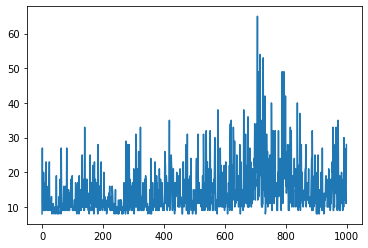

In [19]:
plt.plot(range(max_episodes), total_reward)
plt.show()

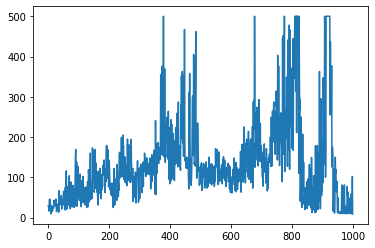

In [9]:
plt.plot(range(max_episodes), total_reward)
plt.show()

In [ ]:
env = gym.make('CartPole-v1')
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
print(state_dim)
print(action_dim)